In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
from nilmtk import STATS_CACHE

from utils.constants import DatasetType, DAY_IN_SEC
from utils.data_reading import clean_and_store_data, read_cleaned_data, \
    convert_to_nilmtk_format, store_processed_stable_periods, \
    get_full_keys_of_stable_periods, read_stable_periods
from utils.preprocessing import generate_sync_signals, get_stable_periods, \
    interpolate_missed_data, generate_async_signals, reformat_to_accumulated
from utils.timing import time_measure
from utils.visualization import plot_sync_async_comparison

STATS_CACHE.store.close()


DS = DatasetType.IDEAL
DURATION = DAY_IN_SEC*30
MAX_GAP = 300

# convert_to_nilmtk_format(DS)
# clean_and_store_data(DS)
# ideal = read_cleaned_data(DS)
# process_stable_periods(DS, DURATION, MAX_GAP)

full_keys = get_full_keys_of_stable_periods(DS)
accumulated = read_stable_periods(DS, [full_keys[0]])[0]

[reading 1 stable periods of IDEAL] finished in 0m 0.11s


In [3]:
sync_signals = generate_sync_signals(accumulated, 100)
print('len(sync_signals)', len(sync_signals))

async_signals = generate_async_signals(accumulated, 60000)
print('len(async_signals)', len(async_signals))

[generating sync signals] finished in 0m 0.00s
len(sync_signals) 25921
[generating async signals] finished in 0m 0.31s
len(async_signals) 25475


In [34]:
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator  # PCHIP 1-D monotonic cubic interpolation
from scipy.interpolate import CubicSpline, UnivariateSpline, InterpolatedUnivariateSpline, splrep, splev, PPoly
from scipy.integrate import quad as integrate
from numpy.polynomial.polynomial import Polynomial

from utils.constants import MONTH_IN_SEC
from utils.preprocessing import datetime_index_to_floats
from utils.timing import time_measure
import matplotlib.pyplot as plt


def accumulated_distance(original: pd.Series, generated: pd.Series):
    with time_measure(f'accumulated_distance'):
        f_dates_orig = datetime_index_to_floats(original.index)
        f_dates_gen = datetime_index_to_floats(generated.index)
        united_dates = f_dates_orig.union(f_dates_gen)
        lin_orig = InterpolatedUnivariateSpline(f_dates_orig, original.values, k=1)
        lin_gen = InterpolatedUnivariateSpline(f_dates_gen, generated.values, k=1)
        all_values_orig = lin_orig(united_dates)
        all_values_gen = lin_gen(united_dates)
        diff = all_values_orig - all_values_gen
        
#         print('diff')
#         print(diff)
#         print('all_values_orig')
#         print(all_values_orig)
#         print('all_values_gen')
#         print(all_values_gen)
        
#         print('gen1', generated.values[1])
#         print(f_dates_gen)
        
#         print('dates')
#         print(united_dates)
#         print('diff')
#         print(diff)
#         lin_diff = InterpolatedUnivariateSpline(united_dates, diff, k=1)

        point_count = len(united_dates)
        
        tck = splrep(united_dates, diff, k=1, s=0)
        interpolations = PPoly.from_spline(tck)

#         print('coefs')
#         print(interpolations.c)
#         print('interpolations.x')
#         print(interpolations.x / 10**6)
#         print()
        
        assert interpolations.c.shape[0] == 2, 'must be linear'
        assert interpolations.c.shape[1] == point_count + 1
        
        squared_coefs = np.empty((3, point_count + 1), dtype=np.float64)
#         xs = interpolations.x[1:-1]
#         for i in range(point_count - 1):
        for i in range(point_count + 1):
            p = Polynomial(interpolations.c[:, i][::-1]) / 100
            p_squared = p ** 2
#             print('p.coef')
#             print(interpolations.c[:, i][::-1])
#             print('p.coef')
#             print(p.coef)
#             print('p_squared.coef')
#             print(p_squared.coef)
#             print('squared_coefs[None, i]')
#             print(squared_coefs[None, i])
            coefs_to_apply = p_squared.coef[::-1]
            coefs_to_apply = np.pad(coefs_to_apply, (0, 3 - len(coefs_to_apply)))
#             print(type(coefs_to_apply))
            for ind, c in enumerate(coefs_to_apply):
                squared_coefs[ind, i] = c
            interval = np.linspace(interpolations.x[i], interpolations.x[i+1], 10)
#             plt.plot(interval, interpolations(interval), 'x', label='interpolations')
#             plt.plot(interval, p(interval-interpolations.x[i])*100, 'x', label='Polynomial')
#             plt.plot(interval, p_squared(interval-interpolations.x[i]), 'x', label='Polynomial squared')
        
        plt.plot(f_dates_orig, original.values, 'x', label='orig')
        plt.plot(f_dates_gen, generated.values, '-', label='gen')
#         plt.plot(united_dates, all_values_orig, '--', label='orig_lin')
#         plt.plot(united_dates, all_values_gen, ':', label='gen_lin')
        
        plt.plot(united_dates, diff, ':', label='diff')
#         plt.plot(united_dates, ppoly(united_dates), 'x:', label='ppoly')
#         plt.legend(loc = 'best')
        plt.show()
        
        squared_diffs = PPoly(squared_coefs, interpolations.x)

#         print('squared_coefs')
#         print(squared_coefs)
#         print('xs')
#         print(xs / 10**6)
#         print()

#         print('squared_diffs.c')
#         print(squared_diffs.c)
#         print('squared_diffs.x')
#         print(squared_diffs.x / 10**6)
        
        distance = squared_diffs.integrate(united_dates[0], united_dates[-1])
        print('distance')
        print(distance)
        
        
        
#         return squared_diffs
    # with time_measure(f'integrating'):
    #     dist = integrate(lambda x: abs(lin_orig(x) - lin_gen(x)),
    #                      united_dates[0], united_dates[-1],
    #                      points=united_dates, limit=len(united_dates) + 10)
    # return dist




def consumption_rate_distance():
    pass




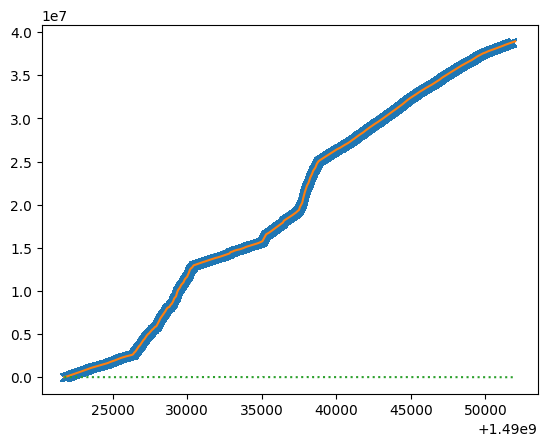

distance
18933408.153005347
[accumulated_distance] finished in 0m 5.54s


In [37]:
accumulated_distance(accumulated[:30000], async_signals[:650])

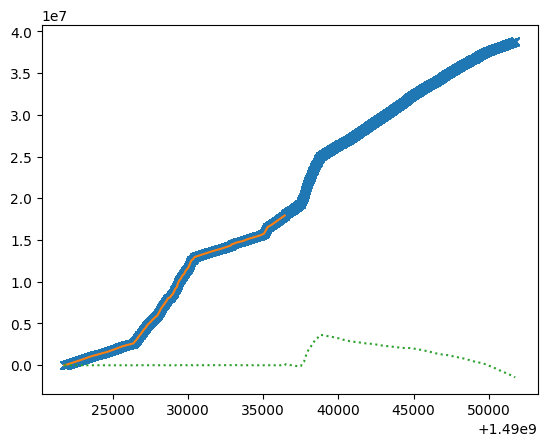

distance
6162284193676.401
[accumulated_distance] finished in 0m 5.49s


In [38]:
accumulated_distance(accumulated[:30000], async_signals[:300])

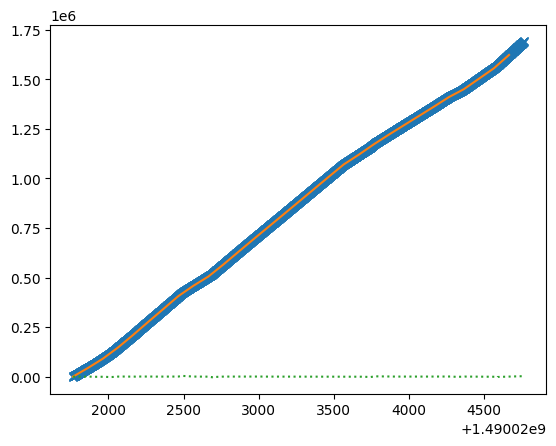

distance
175728.18928436347
[accumulated_distance] finished in 0m 0.70s


In [41]:
accumulated_distance(accumulated[:3000], sync_signals[:30])

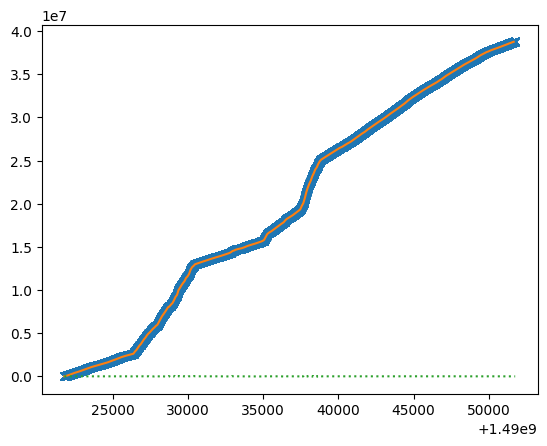

distance
291978868.7456687
[accumulated_distance] finished in 0m 5.57s


In [40]:
accumulated_distance(accumulated[:30000], sync_signals[:300])

In [7]:
accumulated_distance(accumulated[:100000], async_signals[:1000])

[[1.93526904e+01 1.93526904e+01 1.19212701e-02 ... 3.13493529e+01
  3.13493531e+01 3.13493531e+01]
 [0.00000000e+00 0.00000000e+00 9.60642802e-01 ... 1.99871501e+06
  1.99877771e+06 1.99884041e+06]
 [0.00000000e+00 0.00000000e+00 1.93526904e+01 ... 3.18576088e+10
  3.18596075e+10 3.18616064e+10]]
distance
170770353926498.44
[accumulated_distance] finished in 0m 16.28s


In [9]:
accumulated_distance(accumulated, async_signals)

distance
1390055122.5904725
[accumulated_distance] finished in 7m 48.17s


In [238]:
# accumulated_distance(accumulated[:len(accumulated)//1000], async_signals[:len(async_signals)//1000])
accumulated_distance(accumulated[:500], async_signals[:5])
accumulated_distance(accumulated, async_signals)
# accumulated_distance(accumulated[:50], accumulated[:50])

distance
15512.302950351565
[accumulated_distance] finished in 0m 0.03s
distance
1390055122.5904725
[accumulated_distance] finished in 1m 59.74s


In [239]:
accumulated_distance(accumulated, sync_signals)

distance
6760747951.956481
[accumulated_distance] finished in 1m 59.98s


In [240]:
1390055122.5904725 / 6760747951.956481

0.2056067069011509

In [157]:
interpolations.c[:, 0]
print(interpolations.c.shape)

(3, 10)


In [28]:
polinomials = []
for i in range(interpolations.c.shape[1]):
    p = Polynomial(interpolations.c[:, i])
    print(p)
    polinomials.append(p)



-439.91692838 + 0.0 x
-439.91692838 + 0.0 x
-10.91845687 - 439.91692838 x
4.08154313 - 450.83538526 x
-0.91845687 - 446.75384213 x
-0.91845687 - 447.67229901 x
-64.85591217 - 569.26580597 x
-183.21346995 - 8292.41569115 x
-206.9261825 - 25959.67737557 x
-206.9261825 - 45181.02384902 x


In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator  # PCHIP 1-D monotonic cubic interpolation
from scipy.interpolate import CubicSpline, UnivariateSpline, InterpolatedUnivariateSpline, splrep, splev, PPoly
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 10)
y = np.cos(x**2/3+4)
xnew = np.linspace(0, 10, 75)

tck = splrep(x, y, k=1, s=0)
f1 = PPoly.from_spline(tck)
f2 = InterpolatedUnivariateSpline(x, y, k=1)

plt.plot(x, y, 'o', xnew, np.cos(xnew**2/3+4), ':', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'real', 'PPoly', 'InterpolatedUnivariateSpline'], loc = 'best')
plt.show()